In [1]:
# !pip install opencv-python
# !pip install numpy
# !pip install matplotlib
# !pip install tqdm
# !pip3 install torch torchvision torchaudio
# !pip install scikit-learn

In [2]:
import cv2
import numpy as np
import os

# Define the main directory
main_dir = './aug data'

# Define subdirectories for train, val, and test
subdirectories = ['train', 'val', 'test']

train_dir = os.path.join(main_dir, subdirectories[0])
val_dir = os.path.join(main_dir, subdirectories[1])
test_dir = os.path.join(main_dir, subdirectories[2])


In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get the list of image files
all_files = os.listdir(train_dir)
image_files = [file for file in all_files if file.lower().endswith('.jpg')]

y_label = []

# Process each image
for image_file in tqdm(image_files):
    # Load the corresponding annotation
    annotation_path = os.path.join(train_dir, image_file.replace(".jpg", ".txt"))
    with open(annotation_path, "r") as f:
        annotation_data = list(map(float, f.read().split()))

    # Process the annotation data
    label = int(annotation_data[0])
    bbox = annotation_data[1:]

    y_label.append(label)

# Convert lists to NumPy arrays
y_label = np.array(y_label)
print(len(np.unique(y_label)))


100%|████████████████████| 2113/2113 [00:00<00:00, 10794.13it/s]

10


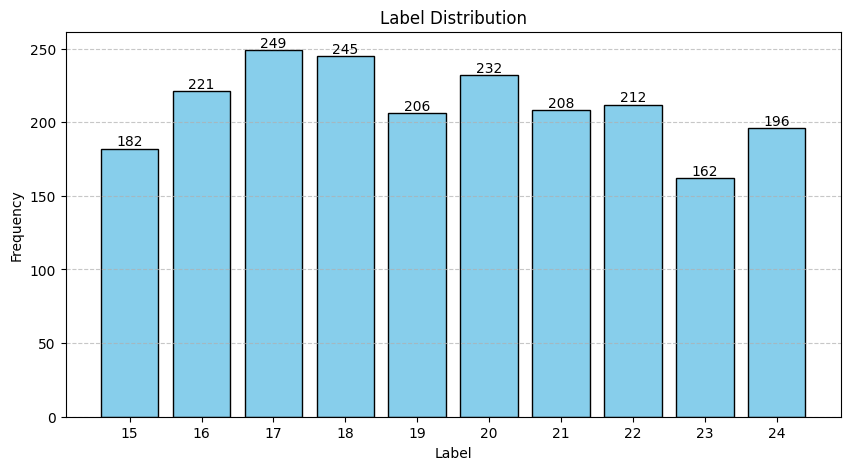

In [4]:
# Visualize label distribution
plt.figure(figsize=(10, 5))
plt.hist(y_label, bins=np.arange(y_label.min(), y_label.max() + 2) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(np.arange(y_label.min(), y_label.max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adding text annotations
for i in range(len(np.unique(y_label))):
    count = np.sum(y_label == i+15)
    plt.text(i+15, count, str(count), ha='center', va='bottom')

plt.show()

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


class_weights = compute_class_weight(class_weight ='balanced', classes = np.unique(y_label), y = y_label)
# class_weights = [weight / sum(class_weights) for weight in class_weights]
class_weights = torch.FloatTensor([class_weights[i] for i in range(len(class_weights))]).to(device)

print(len(np.unique(y_label)))
print(class_weights)

cuda
10
tensor([1.1610, 0.9561, 0.8486, 0.8624, 1.0257, 0.9108, 1.0159, 0.9967, 1.3043,
        1.0781], device='cuda:0')


In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image, ImageFilter
import os
from sklearn.model_selection import train_test_split
import random



seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)


class HumanActivityDataset(Dataset):
    def __init__(self, images_folder, transform=None, split='train'):
        self.images_folder = images_folder
        self.annotations_folder = images_folder
        self.transform = transform

        all_files = os.listdir(images_folder)
        self.image_files = [file for file in all_files if file.lower().endswith('.jpg')]
        self.annotation_files = [file for file in all_files if file.lower().endswith('.txt')]
        self.min_label_value = 15

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        # Load annotation
        annotation_name = os.path.join(self.annotations_folder, self.annotation_files[idx])
        with open(annotation_name, 'r') as file:
            annotation = file.readline().strip().split()

        # Extract label and bounding box coordinates
        label = int(float(annotation[0]))
        label = int(float(annotation[0])) - self.min_label_value
        # print(label)

        center_x, center_y, width, height = map(float, annotation[1:])

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Return the resized bounding box coordinates
        resized_bbox = [center_x, center_y, width, height]
        return image, (label, torch.tensor(resized_bbox))



# Example usage:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

# Split the dataset into train, validation, and test sets
train_dataset = HumanActivityDataset(train_dir, transform=transform, split='train')
val_dataset = HumanActivityDataset(val_dir, transform=transform, split='val')
test_dataset = HumanActivityDataset(test_dir, transform=transform, split='test')

# Example: Accessing a sample
sample_image, sample_annotation = train_dataset[0]
label, bbox = sample_annotation

# Example: Creating DataLoader for training
from torch.utils.data import DataLoader, WeightedRandomSampler

batch_size = 32

# sampler = WeightedRandomSampler(class_weights, len(train_dataset), replacement=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)# sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
import matplotlib.patches as patches

def show_image_with_bbox(image, annotation):
    label, bbox = annotation

    # Convert (center_x, center_y, width, height) to (xmin, ymin, width, height)
    xmin = int((bbox[0] - bbox[2] / 2) * image.shape[2])
    ymin = int((bbox[1] - bbox[3] / 2) * image.shape[1])
    width = int((bbox[0] + bbox[2] / 2) * image.shape[2]) - xmin
    height = int((bbox[1] + bbox[3] / 2) * image.shape[1]) - ymin

    image = image.numpy().transpose((1, 2, 0))
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1]-5, f'Label: {label}', color='r')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6, tensor([0.5169, 0.5329, 0.7780, 0.9775]))


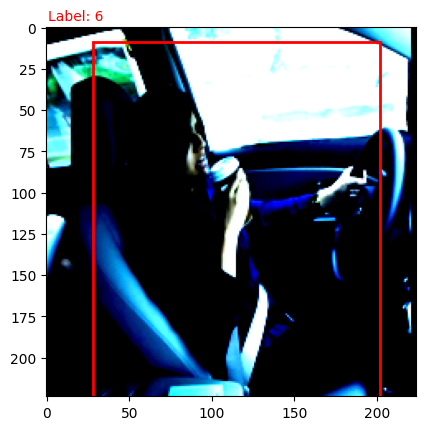

torch.Size([3, 224, 224])


In [23]:
sample_image, sample_annotation = train_dataset[2000]
print(sample_annotation)
show_image_with_bbox(sample_image, sample_annotation)
print(sample_image.shape)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.nn.functional as F



class CustomResNet101(nn.Module):
    def __init__(self, num_classes, feature_extract, bbox_size=4, dropout_rate=0):
        super(CustomResNet101, self).__init__()
        self.resnet = models.resnet101(pretrained=True, progress=True)
        # set_parameter_requires_grad(self.resnet, feature_extract)

        # Determine the number of layers you want to freeze
        if feature_extract:
            # Freeze all layers except the final fully connected layer
            for name, param in self.resnet.named_parameters():
                # if "fc" not in name:
                param.requires_grad = False


        num_features = self.resnet.fc.in_features  # Update to use the correct attribute
        self.resnet.fc = nn.Identity()

        self.dropout = nn.Dropout(p=dropout_rate)

        # Add separate fully connected layers for classification and bounding box regression
        self.fc_label1 = nn.Linear(num_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
        self.fc_bbox = nn.Linear(num_features, bbox_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        features = self.resnet(x).squeeze()
        features = self.dropout(features)

        label_output = self.fc_label1(features)
        # print(f"Before Softmax: {label_output}")
        label_output = self.softmax(label_output)
        # print(f"After Softmax: {label_output}")


        bbox_output = self.fc_bbox(features)
        bbox_output = self.relu(bbox_output)

        return label_output, bbox_output

In [10]:
num_classes = 10
feature_extract=False
model = CustomResNet101(num_classes, feature_extract)

# criterion_label = nn.CrossEntropyLoss(weight=class_weights)
criterion_label = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()  # Use appropriate regression loss for bounding box
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 100

model.to(device)

/mnt/6C44792F4478FD60/Software ENG/Projects/human-activity-detection/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/6C44792F4478FD60/Software ENG/Projects/human-activity-detection/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResNet101(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [11]:
from torch.nn.utils import clip_grad_norm_

# Lists to store metrics for plotting
train_loss_label_history = []
train_loss_bbox_history = []
val_loss_label_history = []
val_loss_bbox_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss_label = 0.0
    running_loss_bbox = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    for images, (labels, bbox) in tqdm(train_dataloader):
        images, labels, bbox = images.to(device), labels.to(device), bbox.to(device)
        if images.size(0) > 1:    
            optimizer.zero_grad()
    
            label_output, bbox_output = model(images)
    
            loss_label = criterion_label(label_output, labels)
            loss_bbox = criterion_bbox(bbox_output, bbox)
    
            total_loss = 1 * loss_label + 1 * loss_bbox

            # loss_label.backward(retain_graph=True)
            total_loss.backward()
            # Apply gradient clipping
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

        running_loss_label += loss_label.item()
        running_loss_bbox += loss_bbox.item()

        _, predicted_labels_train = torch.max(label_output, 1)
        # print(predicted_labels_train)
        # print(labels)
        correct_predictions_train += (predicted_labels_train == labels).sum().item()
        total_samples_train += labels.size(0)

    train_loss_label = running_loss_label / len(train_dataloader)
    train_loss_bbox = running_loss_bbox / len(train_dataloader)
    
    train_accuracy = correct_predictions_train / total_samples_train
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss Label: {train_loss_label}, Train Loss Bbox: {train_loss_bbox}, Train Accuracy: {train_accuracy}")
    scheduler.step()

    # Validation
    model.eval()
    val_loss_label = 0.0
    val_loss_bbox = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for val_images, (val_labels, val_bbox) in val_dataloader:
            val_images, val_labels, val_bbox = val_images.to(device), val_labels.to(device), val_bbox.to(device)

            val_label_output, val_bbox_output = model(val_images)
            val_loss_label += criterion_label(val_label_output, val_labels).item()
            val_loss_bbox += criterion_bbox(val_bbox_output, val_bbox).item()

            _, predicted_labels_val = torch.max(val_label_output, 1)
            correct_predictions_val += (predicted_labels_val == val_labels).sum().item()
            total_samples_val += val_labels.size(0)

    val_loss_label /= len(val_dataloader)
    val_loss_bbox /= len(val_dataloader)
    val_accuracy = correct_predictions_val / total_samples_val
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss Label: {val_loss_label}, Val Loss bbox: {val_loss_bbox}, Val Accuracy: {val_accuracy}")

    # Store metrics for plotting
    train_loss_label_history.append(train_loss_label)
    train_loss_bbox_history.append(train_loss_bbox)
    val_loss_label_history.append(val_loss_label)
    val_loss_bbox_history.append(val_loss_bbox)
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)

100%|███████████████████████████| 67/67 [00:47<00:00,  1.42it/s]


Epoch 1/100, Train Loss Label: 2.1350126586743254, Train Loss Bbox: 0.019660611873242393, Train Accuracy: 0.32796971131093233
Epoch 1/100, Val Loss Label: 1.8523469473186291, Val Loss bbox: 0.006180575387062211, Val Accuracy: 0.6533996683250415


100%|███████████████████████████| 67/67 [00:47<00:00,  1.42it/s]


Epoch 2/100, Train Loss Label: 1.8701257972574945, Train Loss Bbox: 0.005173939794524392, Train Accuracy: 0.6076668244202555
Epoch 2/100, Val Loss Label: 1.7111836295378835, Val Loss bbox: 0.004523211060778091, Val Accuracy: 0.7611940298507462


100%|███████████████████████████| 67/67 [00:47<00:00,  1.42it/s]


Epoch 3/100, Train Loss Label: 1.8130004174673735, Train Loss Bbox: 0.004662271057352868, Train Accuracy: 0.6564126833885471
Epoch 3/100, Val Loss Label: 1.6884643466849076, Val Loss bbox: 0.005203891373974712, Val Accuracy: 0.7810945273631841


100%|███████████████████████████| 67/67 [00:47<00:00,  1.41it/s]


Epoch 4/100, Train Loss Label: 1.7969441235955081, Train Loss Bbox: 0.004536034584518021, Train Accuracy: 0.6715570279223853
Epoch 4/100, Val Loss Label: 1.681637914557206, Val Loss bbox: 0.005836502501839085, Val Accuracy: 0.7827529021558872


100%|███████████████████████████| 67/67 [00:47<00:00,  1.40it/s]


Epoch 5/100, Train Loss Label: 1.7831432641442142, Train Loss Bbox: 0.004259046848251748, Train Accuracy: 0.6819687647893989
Epoch 5/100, Val Loss Label: 1.6772921085357666, Val Loss bbox: 0.00478251311486881, Val Accuracy: 0.7827529021558872


100%|███████████████████████████| 67/67 [00:47<00:00,  1.40it/s]


Epoch 6/100, Train Loss Label: 1.7650198580613776, Train Loss Bbox: 0.0030274349369053075, Train Accuracy: 0.6990061523899669
Epoch 6/100, Val Loss Label: 1.6609196349194175, Val Loss bbox: 0.003404584958365089, Val Accuracy: 0.8009950248756219


100%|███████████████████████████| 67/67 [00:48<00:00,  1.40it/s]


Epoch 7/100, Train Loss Label: 1.7536076147164872, Train Loss Bbox: 0.0028490841166297002, Train Accuracy: 0.7094178892569806
Epoch 7/100, Val Loss Label: 1.6606788196061786, Val Loss bbox: 0.003350121152930354, Val Accuracy: 0.8009950248756219


100%|███████████████████████████| 67/67 [00:47<00:00,  1.40it/s]


Epoch 8/100, Train Loss Label: 1.7481648850796827, Train Loss Bbox: 0.0027869925312975895, Train Accuracy: 0.7155702792238523
Epoch 8/100, Val Loss Label: 1.660201775400262, Val Loss bbox: 0.00334733687831383, Val Accuracy: 0.802653399668325


100%|███████████████████████████| 67/67 [00:47<00:00,  1.40it/s]


Epoch 9/100, Train Loss Label: 1.7395996994047023, Train Loss Bbox: 0.002664248095894816, Train Accuracy: 0.7245622337908187
Epoch 9/100, Val Loss Label: 1.6618089864128514, Val Loss bbox: 0.0034987871951766706, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [00:48<00:00,  1.39it/s]


Epoch 10/100, Train Loss Label: 1.7362460538522522, Train Loss Bbox: 0.0026511223917243198, Train Accuracy: 0.7259820160908661
Epoch 10/100, Val Loss Label: 1.6679217187981856, Val Loss bbox: 0.0034337204170266263, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [00:48<00:00,  1.39it/s]


Epoch 11/100, Train Loss Label: 1.7340616859606843, Train Loss Bbox: 0.002518510586693327, Train Accuracy: 0.7321344060577378
Epoch 11/100, Val Loss Label: 1.669069478386327, Val Loss bbox: 0.0033475332035634076, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [00:48<00:00,  1.39it/s]


Epoch 12/100, Train Loss Label: 1.730274712861474, Train Loss Bbox: 0.0024352282070235084, Train Accuracy: 0.7340274491244676
Epoch 12/100, Val Loss Label: 1.666112366475557, Val Loss bbox: 0.003340860167028088, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [00:48<00:00,  1.38it/s]


Epoch 13/100, Train Loss Label: 1.7293969641870528, Train Loss Bbox: 0.0024408992595359017, Train Accuracy: 0.7326076668244202
Epoch 13/100, Val Loss Label: 1.6676614096290188, Val Loss bbox: 0.0033486435483945044, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [00:48<00:00,  1.39it/s]


Epoch 14/100, Train Loss Label: 1.731324512567093, Train Loss Bbox: 0.002418485325900143, Train Accuracy: 0.7316611452910554
Epoch 14/100, Val Loss Label: 1.6673893740302639, Val Loss bbox: 0.0033383548970481285, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [00:48<00:00,  1.37it/s]


Epoch 15/100, Train Loss Label: 1.7327652600274157, Train Loss Bbox: 0.0024673984691834273, Train Accuracy: 0.7326076668244202
Epoch 15/100, Val Loss Label: 1.6665438539103459, Val Loss bbox: 0.0033526155166327953, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [00:48<00:00,  1.38it/s]


Epoch 16/100, Train Loss Label: 1.7287248034975422, Train Loss Bbox: 0.002428766270515634, Train Accuracy: 0.7340274491244676
Epoch 16/100, Val Loss Label: 1.6665660017415096, Val Loss bbox: 0.003356453962624073, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [00:49<00:00,  1.36it/s]


Epoch 17/100, Train Loss Label: 1.7309270527825427, Train Loss Bbox: 0.0024155829720365913, Train Accuracy: 0.73450070989115
Epoch 17/100, Val Loss Label: 1.6655041983253078, Val Loss bbox: 0.0033490435514403017, Val Accuracy: 0.8009950248756219


100%|███████████████████████████| 67/67 [00:48<00:00,  1.38it/s]


Epoch 18/100, Train Loss Label: 1.728944096992265, Train Loss Bbox: 0.0024127893240204943, Train Accuracy: 0.735447231424515
Epoch 18/100, Val Loss Label: 1.6652689983970241, Val Loss bbox: 0.0033537169526282108, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [00:48<00:00,  1.37it/s]


Epoch 19/100, Train Loss Label: 1.728031345267794, Train Loss Bbox: 0.002423150115646422, Train Accuracy: 0.73450070989115
Epoch 19/100, Val Loss Label: 1.6648620618017096, Val Loss bbox: 0.0033542734423750325, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [00:48<00:00,  1.38it/s]


Epoch 20/100, Train Loss Label: 1.728760557388192, Train Loss Bbox: 0.0024159163351295822, Train Accuracy: 0.7335541883577852
Epoch 20/100, Val Loss Label: 1.6659724210437976, Val Loss bbox: 0.003357078634986752, Val Accuracy: 0.8009950248756219


100%|███████████████████████████| 67/67 [00:49<00:00,  1.36it/s]


Epoch 21/100, Train Loss Label: 1.7298542083199344, Train Loss Bbox: 0.0024224535558622943, Train Accuracy: 0.7330809275911027
Epoch 21/100, Val Loss Label: 1.666000905789827, Val Loss bbox: 0.003364700186801584, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [00:48<00:00,  1.37it/s]


Epoch 22/100, Train Loss Label: 1.730138940597648, Train Loss Bbox: 0.002382619773843951, Train Accuracy: 0.73450070989115
Epoch 22/100, Val Loss Label: 1.6666724054436934, Val Loss bbox: 0.0033547845056378527, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [00:49<00:00,  1.36it/s]


Epoch 23/100, Train Loss Label: 1.7274802549561459, Train Loss Bbox: 0.0024002573154032676, Train Accuracy: 0.735447231424515
Epoch 23/100, Val Loss Label: 1.6664817144996242, Val Loss bbox: 0.003363640464254116, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [00:49<00:00,  1.36it/s]


Epoch 24/100, Train Loss Label: 1.727546578022971, Train Loss Bbox: 0.0023962153198280886, Train Accuracy: 0.73450070989115
Epoch 24/100, Val Loss Label: 1.6665188262337132, Val Loss bbox: 0.003347349929084119, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [00:49<00:00,  1.37it/s]


Epoch 25/100, Train Loss Label: 1.727858749788199, Train Loss Bbox: 0.002400307398317243, Train Accuracy: 0.7349739706578324
Epoch 25/100, Val Loss Label: 1.667687083545484, Val Loss bbox: 0.003352656151707235, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [00:49<00:00,  1.36it/s]


Epoch 26/100, Train Loss Label: 1.7278251630156787, Train Loss Bbox: 0.00239470947373992, Train Accuracy: 0.7349739706578324
Epoch 26/100, Val Loss Label: 1.6649419508482282, Val Loss bbox: 0.0033517983055820592, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [00:49<00:00,  1.37it/s]


Epoch 27/100, Train Loss Label: 1.7272363865553444, Train Loss Bbox: 0.0024183779805481654, Train Accuracy: 0.7349739706578324
Epoch 27/100, Val Loss Label: 1.6658117833890413, Val Loss bbox: 0.0033547924954052035, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [00:49<00:00,  1.36it/s]


Epoch 28/100, Train Loss Label: 1.7272206544876099, Train Loss Bbox: 0.002438822590898889, Train Accuracy: 0.7359204921911974
Epoch 28/100, Val Loss Label: 1.6661667510082847, Val Loss bbox: 0.0033557876013219357, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [00:49<00:00,  1.36it/s]


Epoch 29/100, Train Loss Label: 1.7288493914390677, Train Loss Bbox: 0.0023970838493681443, Train Accuracy: 0.735447231424515
Epoch 29/100, Val Loss Label: 1.6665066982570447, Val Loss bbox: 0.0033505839222159827, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [00:49<00:00,  1.35it/s]


Epoch 30/100, Train Loss Label: 1.7290325164794922, Train Loss Bbox: 0.0023903640407596286, Train Accuracy: 0.7326076668244202
Epoch 30/100, Val Loss Label: 1.663701145272506, Val Loss bbox: 0.003348323492039191, Val Accuracy: 0.8009950248756219


100%|███████████████████████████| 67/67 [00:49<00:00,  1.35it/s]


Epoch 31/100, Train Loss Label: 1.7282516120085076, Train Loss Bbox: 0.0023997536332193595, Train Accuracy: 0.7359204921911974
Epoch 31/100, Val Loss Label: 1.6660618280109607, Val Loss bbox: 0.0033458579258110964, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [00:49<00:00,  1.35it/s]


Epoch 32/100, Train Loss Label: 1.7289237353339124, Train Loss Bbox: 0.002406404179924015, Train Accuracy: 0.73450070989115
Epoch 32/100, Val Loss Label: 1.6656277179718018, Val Loss bbox: 0.0033491394654112426, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 33/100, Train Loss Label: 1.7289932450251793, Train Loss Bbox: 0.002415594973239992, Train Accuracy: 0.7321344060577378
Epoch 33/100, Val Loss Label: 1.6666157747569836, Val Loss bbox: 0.0033611156855170663, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 34/100, Train Loss Label: 1.7283771020262988, Train Loss Bbox: 0.0024044047241835896, Train Accuracy: 0.7349739706578324
Epoch 34/100, Val Loss Label: 1.6657219686006244, Val Loss bbox: 0.0033541813027113676, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 35/100, Train Loss Label: 1.7301253703103137, Train Loss Bbox: 0.00241480060025994, Train Accuracy: 0.7321344060577378
Epoch 35/100, Val Loss Label: 1.6653355736481517, Val Loss bbox: 0.0033579879366841757, Val Accuracy: 0.8009950248756219


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 36/100, Train Loss Label: 1.7295710453346593, Train Loss Bbox: 0.0023876382194376036, Train Accuracy: 0.73450070989115
Epoch 36/100, Val Loss Label: 1.6656623702300222, Val Loss bbox: 0.0033518391734871423, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 37/100, Train Loss Label: 1.729279302839023, Train Loss Bbox: 0.0024208795095084987, Train Accuracy: 0.735447231424515
Epoch 37/100, Val Loss Label: 1.6673967963770817, Val Loss bbox: 0.0033449180497738874, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 38/100, Train Loss Label: 1.727488957234283, Train Loss Bbox: 0.002418520566729356, Train Accuracy: 0.7363937529578798
Epoch 38/100, Val Loss Label: 1.6682406099219071, Val Loss bbox: 0.003349151180468892, Val Accuracy: 0.7927031509121062


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 39/100, Train Loss Label: 1.7272141816011115, Train Loss Bbox: 0.0024065841145730063, Train Accuracy: 0.735447231424515
Epoch 39/100, Val Loss Label: 1.6650431846317493, Val Loss bbox: 0.003357021689513012, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 40/100, Train Loss Label: 1.7278060414897862, Train Loss Bbox: 0.0024253445740010757, Train Accuracy: 0.735447231424515
Epoch 40/100, Val Loss Label: 1.6651479695972644, Val Loss bbox: 0.0033520230484244073, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 41/100, Train Loss Label: 1.7291638797788478, Train Loss Bbox: 0.002419751212209352, Train Accuracy: 0.7330809275911027
Epoch 41/100, Val Loss Label: 1.6658493217669035, Val Loss bbox: 0.0033522319220202533, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 42/100, Train Loss Label: 1.7292988104606741, Train Loss Bbox: 0.0024043739905386273, Train Accuracy: 0.7335541883577852
Epoch 42/100, Val Loss Label: 1.6667998088033575, Val Loss bbox: 0.0033523000066021554, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [01:15<00:00,  1.12s/it]


Epoch 43/100, Train Loss Label: 1.7291586772719425, Train Loss Bbox: 0.0024115682367596833, Train Accuracy: 0.7335541883577852
Epoch 43/100, Val Loss Label: 1.6669652838456004, Val Loss bbox: 0.003354362653274285, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 44/100, Train Loss Label: 1.72936322795811, Train Loss Bbox: 0.002422185917037414, Train Accuracy: 0.7330809275911027
Epoch 44/100, Val Loss Label: 1.665858036593387, Val Loss bbox: 0.0033507768530398607, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 45/100, Train Loss Label: 1.7318424093189524, Train Loss Bbox: 0.0024172243307719926, Train Accuracy: 0.7326076668244202
Epoch 45/100, Val Loss Label: 1.666144477693658, Val Loss bbox: 0.0033433675202295967, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 46/100, Train Loss Label: 1.7287678594019875, Train Loss Bbox: 0.002435568643650457, Train Accuracy: 0.7373402744912447
Epoch 46/100, Val Loss Label: 1.6661075855556287, Val Loss bbox: 0.003353220447407741, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 47/100, Train Loss Label: 1.7273107909444552, Train Loss Bbox: 0.0023961153329669764, Train Accuracy: 0.735447231424515
Epoch 47/100, Val Loss Label: 1.6676113542757536, Val Loss bbox: 0.003359435542829727, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 48/100, Train Loss Label: 1.7280082382372957, Train Loss Bbox: 0.002395621744165225, Train Accuracy: 0.7330809275911027
Epoch 48/100, Val Loss Label: 1.6654411303369623, Val Loss bbox: 0.0033536140659922047, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 49/100, Train Loss Label: 1.7291950040788793, Train Loss Bbox: 0.002436708455641212, Train Accuracy: 0.7359204921911974
Epoch 49/100, Val Loss Label: 1.6671486151845831, Val Loss bbox: 0.003342761498826899, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 50/100, Train Loss Label: 1.7290082511617177, Train Loss Bbox: 0.002395519253505922, Train Accuracy: 0.7335541883577852
Epoch 50/100, Val Loss Label: 1.6655038783424778, Val Loss bbox: 0.0033546954785522664, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 51/100, Train Loss Label: 1.7271641848692254, Train Loss Bbox: 0.0023870634665684913, Train Accuracy: 0.7363937529578798
Epoch 51/100, Val Loss Label: 1.665148835433157, Val Loss bbox: 0.003375468248697488, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 52/100, Train Loss Label: 1.7284315112811417, Train Loss Bbox: 0.0024210296592105237, Train Accuracy: 0.7363937529578798
Epoch 52/100, Val Loss Label: 1.6659416336762278, Val Loss bbox: 0.0033576316445281633, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 53/100, Train Loss Label: 1.7297702565122006, Train Loss Bbox: 0.002415478974928273, Train Accuracy: 0.7349739706578324
Epoch 53/100, Val Loss Label: 1.6655670341692472, Val Loss bbox: 0.0033542109089658447, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 54/100, Train Loss Label: 1.7296507394135887, Train Loss Bbox: 0.0024098035246967824, Train Accuracy: 0.7330809275911027
Epoch 54/100, Val Loss Label: 1.6657311916351318, Val Loss bbox: 0.003352136155100245, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:13<00:00,  1.09s/it]


Epoch 55/100, Train Loss Label: 1.7282818929472965, Train Loss Bbox: 0.0024123627018294673, Train Accuracy: 0.7335541883577852
Epoch 55/100, Val Loss Label: 1.6676331758499146, Val Loss bbox: 0.003350376482366731, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 56/100, Train Loss Label: 1.727602061940663, Train Loss Bbox: 0.00236837166785471, Train Accuracy: 0.7335541883577852
Epoch 56/100, Val Loss Label: 1.6653117443385876, Val Loss bbox: 0.0033532173225754185, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 57/100, Train Loss Label: 1.729682808491721, Train Loss Bbox: 0.0024106015413026534, Train Accuracy: 0.735447231424515
Epoch 57/100, Val Loss Label: 1.6663506407486766, Val Loss bbox: 0.003345886122827467, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 58/100, Train Loss Label: 1.7272001522690503, Train Loss Bbox: 0.0024098596473071557, Train Accuracy: 0.7363937529578798
Epoch 58/100, Val Loss Label: 1.66787756744184, Val Loss bbox: 0.003360253930287926, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 59/100, Train Loss Label: 1.730199429526258, Train Loss Bbox: 0.0024265792071402293, Train Accuracy: 0.735447231424515
Epoch 59/100, Val Loss Label: 1.6681960821151733, Val Loss bbox: 0.0033556164585446056, Val Accuracy: 0.7910447761194029


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 60/100, Train Loss Label: 1.7288579086759197, Train Loss Bbox: 0.0023955961553824706, Train Accuracy: 0.73450070989115
Epoch 60/100, Val Loss Label: 1.669713528532731, Val Loss bbox: 0.0033576813967604387, Val Accuracy: 0.7927031509121062


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 61/100, Train Loss Label: 1.7266610291466784, Train Loss Bbox: 0.0024011270247344205, Train Accuracy: 0.7340274491244676
Epoch 61/100, Val Loss Label: 1.6672746382261578, Val Loss bbox: 0.0033487848765952023, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 62/100, Train Loss Label: 1.727175038252304, Train Loss Bbox: 0.0023985516015829437, Train Accuracy: 0.7326076668244202
Epoch 62/100, Val Loss Label: 1.666913484272204, Val Loss bbox: 0.0033581288359863194, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 63/100, Train Loss Label: 1.728252092404152, Train Loss Bbox: 0.0023984504662064917, Train Accuracy: 0.7335541883577852
Epoch 63/100, Val Loss Label: 1.6658188920272023, Val Loss bbox: 0.0033648167981913217, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 64/100, Train Loss Label: 1.7302498959783297, Train Loss Bbox: 0.002413887815522169, Train Accuracy: 0.7335541883577852
Epoch 64/100, Val Loss Label: 1.6655047065333317, Val Loss bbox: 0.0033523508984791605, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 65/100, Train Loss Label: 1.7296154499053955, Train Loss Bbox: 0.002400323911917521, Train Accuracy: 0.73450070989115
Epoch 65/100, Val Loss Label: 1.6664998719566746, Val Loss bbox: 0.0033574748514710287, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 66/100, Train Loss Label: 1.7287287267286386, Train Loss Bbox: 0.0024159026763110017, Train Accuracy: 0.7330809275911027
Epoch 66/100, Val Loss Label: 1.6672893072429456, Val Loss bbox: 0.003356502023770621, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 67/100, Train Loss Label: 1.727683006827511, Train Loss Bbox: 0.0024378303431474894, Train Accuracy: 0.735447231424515
Epoch 67/100, Val Loss Label: 1.6658378274817216, Val Loss bbox: 0.0033509986426093078, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 68/100, Train Loss Label: 1.728756628819366, Train Loss Bbox: 0.0023938175325573826, Train Accuracy: 0.7349739706578324
Epoch 68/100, Val Loss Label: 1.666970039668836, Val Loss bbox: 0.0033652811972914557, Val Accuracy: 0.7927031509121062


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 69/100, Train Loss Label: 1.7281184836999695, Train Loss Bbox: 0.0024006530944841787, Train Accuracy: 0.735447231424515
Epoch 69/100, Val Loss Label: 1.6674760329095941, Val Loss bbox: 0.003346564211441498, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 70/100, Train Loss Label: 1.7285217224661984, Train Loss Bbox: 0.0024092097579042856, Train Accuracy: 0.7359204921911974
Epoch 70/100, Val Loss Label: 1.6659572563673322, Val Loss bbox: 0.0033488707298314885, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 71/100, Train Loss Label: 1.7283510094258323, Train Loss Bbox: 0.0024124336369863862, Train Accuracy: 0.73450070989115
Epoch 71/100, Val Loss Label: 1.666096800252011, Val Loss bbox: 0.0033456852635074604, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 72/100, Train Loss Label: 1.725920111385744, Train Loss Bbox: 0.002369813542854764, Train Accuracy: 0.7368670137245622
Epoch 72/100, Val Loss Label: 1.667034017412286, Val Loss bbox: 0.0033578914712722365, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 73/100, Train Loss Label: 1.7285199788079333, Train Loss Bbox: 0.0024218991287608643, Train Accuracy: 0.7340274491244676
Epoch 73/100, Val Loss Label: 1.664067782853779, Val Loss bbox: 0.0033532469778468736, Val Accuracy: 0.8009950248756219


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 74/100, Train Loss Label: 1.7307000427103754, Train Loss Bbox: 0.002373632573550428, Train Accuracy: 0.7349739706578324
Epoch 74/100, Val Loss Label: 1.666628128603885, Val Loss bbox: 0.003354367358904136, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 75/100, Train Loss Label: 1.7301939547951541, Train Loss Bbox: 0.0023929356708566646, Train Accuracy: 0.735447231424515
Epoch 75/100, Val Loss Label: 1.6651275910829242, Val Loss bbox: 0.0033556442266624224, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 76/100, Train Loss Label: 1.7291973597967802, Train Loss Bbox: 0.0023947419258140363, Train Accuracy: 0.7359204921911974
Epoch 76/100, Val Loss Label: 1.6660175637194985, Val Loss bbox: 0.0033505122471404703, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.10s/it]


Epoch 77/100, Train Loss Label: 1.7293733305005885, Train Loss Bbox: 0.002448949895090243, Train Accuracy: 0.7335541883577852
Epoch 77/100, Val Loss Label: 1.6684535804547762, Val Loss bbox: 0.0033679394982755184, Val Accuracy: 0.7927031509121062


100%|███████████████████████████| 67/67 [01:14<00:00,  1.10s/it]


Epoch 78/100, Train Loss Label: 1.7274079536324116, Train Loss Bbox: 0.0024118389579842786, Train Accuracy: 0.735447231424515
Epoch 78/100, Val Loss Label: 1.6648865122544139, Val Loss bbox: 0.003346200603501577, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 79/100, Train Loss Label: 1.7284016093211387, Train Loss Bbox: 0.002448979049309421, Train Accuracy: 0.73450070989115
Epoch 79/100, Val Loss Label: 1.667358492550097, Val Loss bbox: 0.0033558732217275782, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 80/100, Train Loss Label: 1.727539354295873, Train Loss Bbox: 0.0024224618804265757, Train Accuracy: 0.73450070989115
Epoch 80/100, Val Loss Label: 1.6646381553850675, Val Loss bbox: 0.0033501697532636555, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 81/100, Train Loss Label: 1.7291383351852645, Train Loss Bbox: 0.002387240697601949, Train Accuracy: 0.735447231424515
Epoch 81/100, Val Loss Label: 1.6647872548354299, Val Loss bbox: 0.003353428414189502, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 82/100, Train Loss Label: 1.7276466995922488, Train Loss Bbox: 0.002419559804569763, Train Accuracy: 0.7349739706578324
Epoch 82/100, Val Loss Label: 1.6655621340400295, Val Loss bbox: 0.0033554714908333202, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 83/100, Train Loss Label: 1.7295593254601778, Train Loss Bbox: 0.0023882839231015142, Train Accuracy: 0.7340274491244676
Epoch 83/100, Val Loss Label: 1.6657080838554783, Val Loss bbox: 0.0033603590717049023, Val Accuracy: 0.8009950248756219


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 84/100, Train Loss Label: 1.726239437487588, Train Loss Bbox: 0.0024182909192628603, Train Accuracy: 0.735447231424515
Epoch 84/100, Val Loss Label: 1.6649400246770758, Val Loss bbox: 0.0033466414009269917, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 85/100, Train Loss Label: 1.7303647087581122, Train Loss Bbox: 0.00240277733702435, Train Accuracy: 0.7340274491244676
Epoch 85/100, Val Loss Label: 1.6696346496280872, Val Loss bbox: 0.00336198076164644, Val Accuracy: 0.7910447761194029


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 86/100, Train Loss Label: 1.7279009107333512, Train Loss Bbox: 0.0023969983744587917, Train Accuracy: 0.7368670137245622
Epoch 86/100, Val Loss Label: 1.6648273718984503, Val Loss bbox: 0.003349882109384788, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 87/100, Train Loss Label: 1.727885296095663, Train Loss Bbox: 0.002426965010991848, Train Accuracy: 0.735447231424515
Epoch 87/100, Val Loss Label: 1.6642525258817171, Val Loss bbox: 0.0033505325034064682, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 88/100, Train Loss Label: 1.728451369413689, Train Loss Bbox: 0.0024008350707451576, Train Accuracy: 0.7330809275911027
Epoch 88/100, Val Loss Label: 1.6654656686280902, Val Loss bbox: 0.0033610097353199593, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 89/100, Train Loss Label: 1.7299271074693594, Train Loss Bbox: 0.002415283473639457, Train Accuracy: 0.7335541883577852
Epoch 89/100, Val Loss Label: 1.6664496848457737, Val Loss bbox: 0.003351306358940507, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 90/100, Train Loss Label: 1.727628997902372, Train Loss Bbox: 0.0023969517562037975, Train Accuracy: 0.7363937529578798
Epoch 90/100, Val Loss Label: 1.6673683680986102, Val Loss bbox: 0.0033576847421691604, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 91/100, Train Loss Label: 1.7286319323440096, Train Loss Bbox: 0.0024078407449953593, Train Accuracy: 0.7359204921911974
Epoch 91/100, Val Loss Label: 1.6664679615121138, Val Loss bbox: 0.0033584327780102428, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 92/100, Train Loss Label: 1.7311433678242698, Train Loss Bbox: 0.0024075737942371575, Train Accuracy: 0.7335541883577852
Epoch 92/100, Val Loss Label: 1.6644419933620251, Val Loss bbox: 0.0033554245448230127, Val Accuracy: 0.8009950248756219


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 93/100, Train Loss Label: 1.7282985306497831, Train Loss Bbox: 0.0023916913005314878, Train Accuracy: 0.7335541883577852
Epoch 93/100, Val Loss Label: 1.6662260356702303, Val Loss bbox: 0.00334558882260401, Val Accuracy: 0.7993366500829188


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 94/100, Train Loss Label: 1.7275262110268892, Train Loss Bbox: 0.002376036678524271, Train Accuracy: 0.7340274491244676
Epoch 94/100, Val Loss Label: 1.6651854013141834, Val Loss bbox: 0.0033514247349414384, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 95/100, Train Loss Label: 1.7302992735336076, Train Loss Bbox: 0.0023927555537657506, Train Accuracy: 0.735447231424515
Epoch 95/100, Val Loss Label: 1.666443015399732, Val Loss bbox: 0.0033571670861228518, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:13<00:00,  1.10s/it]


Epoch 96/100, Train Loss Label: 1.7298750112305825, Train Loss Bbox: 0.0024014998856348112, Train Accuracy: 0.7349739706578324
Epoch 96/100, Val Loss Label: 1.666912267082616, Val Loss bbox: 0.003355165551367559, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 97/100, Train Loss Label: 1.7262301053573836, Train Loss Bbox: 0.002413710193541735, Train Accuracy: 0.7349739706578324
Epoch 97/100, Val Loss Label: 1.6647841867647672, Val Loss bbox: 0.0033543656065471864, Val Accuracy: 0.7976782752902156


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 98/100, Train Loss Label: 1.7268154318652935, Train Loss Bbox: 0.0023989284153916497, Train Accuracy: 0.735447231424515
Epoch 98/100, Val Loss Label: 1.667736291885376, Val Loss bbox: 0.0033457270994978515, Val Accuracy: 0.7943615257048093


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 99/100, Train Loss Label: 1.7290309293946224, Train Loss Bbox: 0.00240750907426839, Train Accuracy: 0.7363937529578798
Epoch 99/100, Val Loss Label: 1.6654972339931287, Val Loss bbox: 0.003354974005273298, Val Accuracy: 0.7960199004975125


100%|███████████████████████████| 67/67 [01:14<00:00,  1.11s/it]


Epoch 100/100, Train Loss Label: 1.7306346306160314, Train Loss Bbox: 0.0024269402475415995, Train Accuracy: 0.7326076668244202
Epoch 100/100, Val Loss Label: 1.6657100539458425, Val Loss bbox: 0.0033559559991485194, Val Accuracy: 0.7960199004975125


In [12]:
model_path = './checkpoint/model.pth'
# Save the model after training
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: ./checkpoint/model.pth


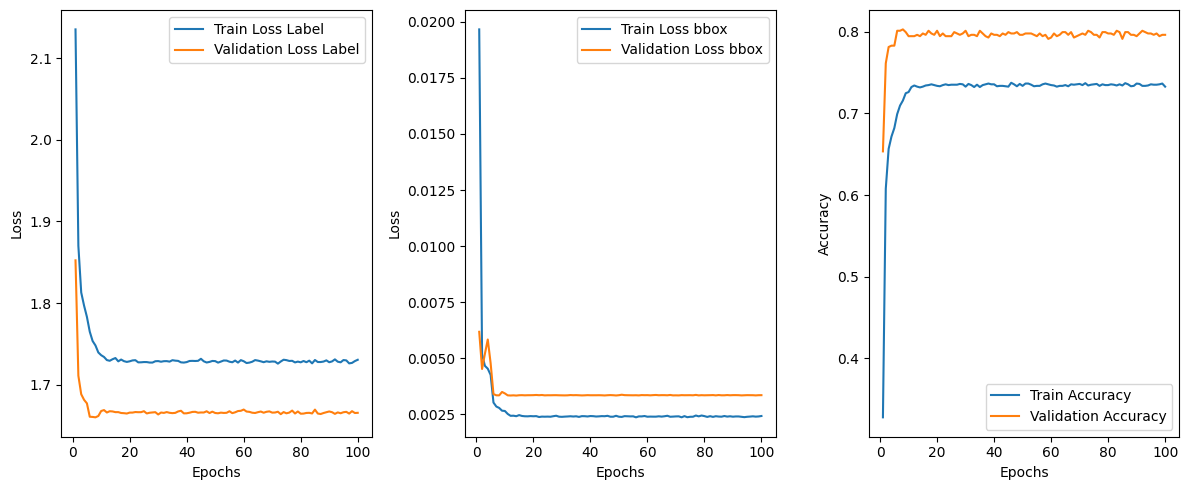

<Figure size 640x480 with 0 Axes>

In [13]:
# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_label_history, label='Train Loss Label')
plt.plot(epochs, val_loss_label_history, label='Validation Loss Label')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, train_loss_bbox_history, label='Train Loss bbox')
plt.plot(epochs, val_loss_bbox_history, label='Validation Loss bbox')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, train_accuracy_history, label='Train Accuracy')
plt.plot(epochs, val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

fig = plt.gcf()
plt.show()
plt.draw()


In [14]:
plot_save_path = './plot.png'
fig.savefig(plot_save_path)
print(f"Plot saved at: {plot_save_path}")

Plot saved at: ./plot.png


In [15]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
def convert_to_xyxy(xcenter, ycenter, width, height):
    x1 = (xcenter - width / 2).cpu().numpy()
    y1 = (ycenter - height / 2).cpu().numpy()
    x2 = (xcenter + width / 2).cpu().numpy()
    y2 = (ycenter + height / 2).cpu().numpy()
    return x1, y1, x2, y2
def calculate_iou(boxes1, boxes2):
    x1_batch, y1_batch, x2_batch, y2_batch = boxes1
    x1_batch_, y1_batch_, x2_batch_, y2_batch_ = boxes2

    # Calculate the coordinates of the intersection area
    inter_x1_batch = np.maximum(x1_batch, x1_batch_)
    inter_y1_batch = np.maximum(y1_batch, y1_batch_)
    inter_x2_batch = np.minimum(x2_batch, x2_batch_)
    inter_y2_batch = np.minimum(y2_batch, y2_batch_)

    # Calculate the area of intersection
    inter_area_batch = np.maximum(0, inter_x2_batch - inter_x1_batch + 1) * np.maximum(0, inter_y2_batch - inter_y1_batch + 1)

    # Calculate the area of union
    area_box1_batch = (x2_batch - x1_batch + 1) * (y2_batch - y1_batch + 1)
    area_box2_batch = (x2_batch_ - x1_batch_ + 1) * (y2_batch_ - y1_batch_ + 1)
    union_area_batch = area_box1_batch + area_box2_batch - inter_area_batch

    # Calculate IOU
    iou_batch = inter_area_batch #/ union_area_batch

    return iou_batch

In [17]:
# Test
model.eval()
test_loss_label = 0.0
test_loss_bbox = 0.0
correct_predictions_test = 0
total_samples_test = 0
total_iou = 0

with torch.no_grad():
    for test_images, (test_labels, test_bbox) in test_dataloader:
        test_images, test_labels, test_bbox = test_images.to(device), test_labels.to(device), test_bbox.to(device)

        test_label_output, test_bbox_output = model(test_images)
        
        test_loss_label += criterion_label(test_label_output, test_labels).item()
        test_loss_bbox += criterion_bbox(test_bbox_output, test_bbox).item()

        _, predicted_labels_test = torch.max(test_label_output, 1)
        correct_predictions_test += (predicted_labels_test == test_labels).sum().item()
        total_samples_test += test_labels.size(0)

        # Convert to (x1, y1, x2, y2) format
        test_bbox = convert_to_xyxy(test_bbox[0], test_bbox[1], test_bbox[2], test_bbox[3])
        test_bbox_output = convert_to_xyxy(test_bbox_output[0], test_bbox_output[1], test_bbox_output[2], test_bbox_output[3])
        
        iou_batch = calculate_iou(test_bbox_output, test_bbox)
        total_iou += np.sum(iou_batch)

test_loss_label /= len(test_dataloader)
test_loss_bbox /= len(test_dataloader)
test_accuracy = correct_predictions_test / total_samples_test
overall_iou = total_iou / total_samples_test


print(f"Test Loss Label: {test_loss_label}, Test Loss bbox: {test_loss_bbox}, Test Accuracy: {test_accuracy}, IOU: {overall_iou}")


Test Loss Label: 1.6806867837905883, Test Loss bbox: 0.0034403591882437466, Test Accuracy: 0.7821782178217822, IOU: 0.3230579741323742


In [18]:
from sklearn.metrics import confusion_matrix, classification_report

all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for test_images, (test_labels, test_bbox) in test_dataloader:
        test_images, test_labels, test_bbox = test_images.to(device), test_labels.to(device), test_bbox.to(device)

        test_label_output, _ = model(test_images)
        _, predicted_labels_test = torch.max(test_label_output, 1)

        all_true_labels.extend(test_labels.cpu().numpy())
        all_predicted_labels.extend(predicted_labels_test.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(all_true_labels, all_predicted_labels)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[21  1  1  0  0  0  0  0  0  0]
 [ 0 25  3  3  0  0  0  0  0  1]
 [ 0  0 28  5  0  1  0  1  0  0]
 [ 0  2  0 28  2  6  0  1  0  0]
 [ 1  0  0  0 26  1  1  0  0  0]
 [ 0  1  0  0  0 24  1  2  3  0]
 [ 0  1  0  0  0  0 20  1  2  1]
 [ 0  3  0  0  0  0  1 31  3  0]
 [ 1  1  2  0  0  1  1  2 19  1]
 [ 2  0  2  0  2  1  0  1  0 15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        23
           1       0.74      0.78      0.76        32
           2       0.78      0.80      0.79        35
           3       0.78      0.72      0.75        39
           4       0.87      0.90      0.88        29
           5       0.71      0.77      0.74        31
           6       0.83      0.80      0.82        25
           7       0.79      0.82      0.81        38
           8       0.70      0.68      0.69        28
           9       0.83      0.65      0.73        23

    accuracy                    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


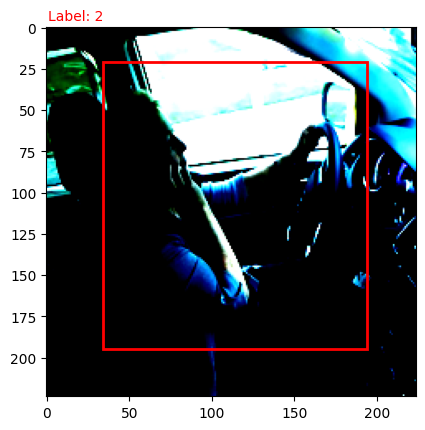

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


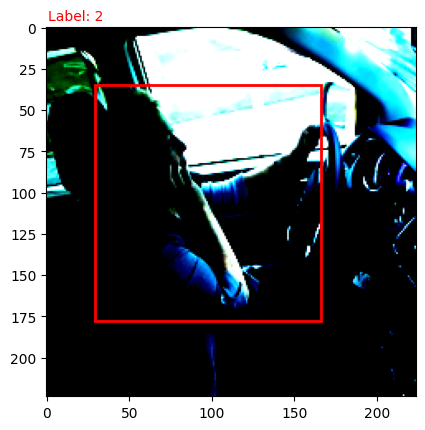

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


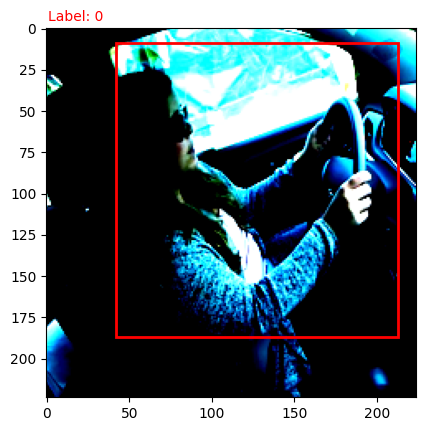

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


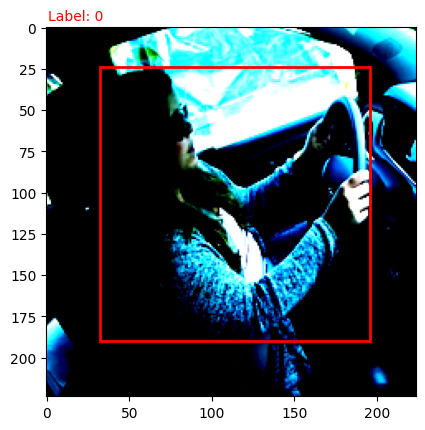

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


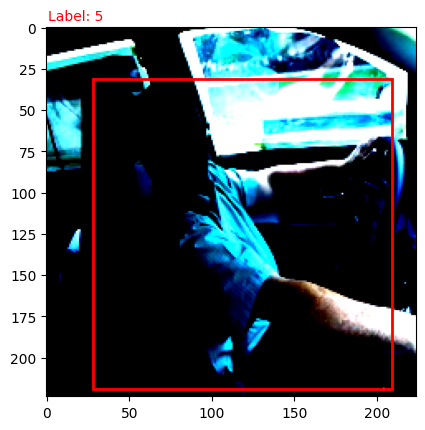

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


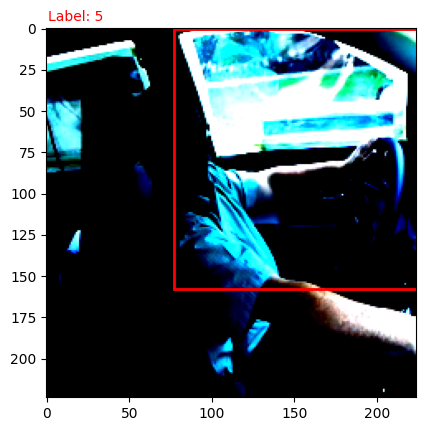

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


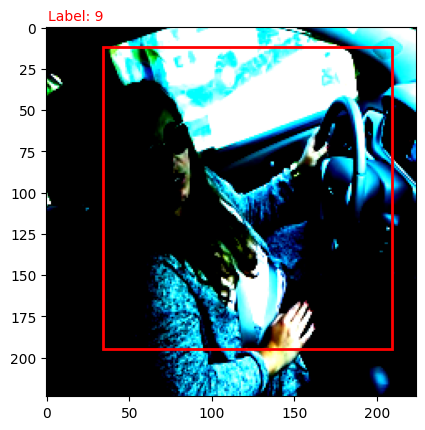

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


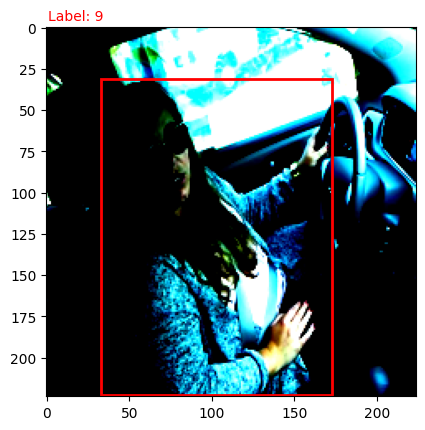

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


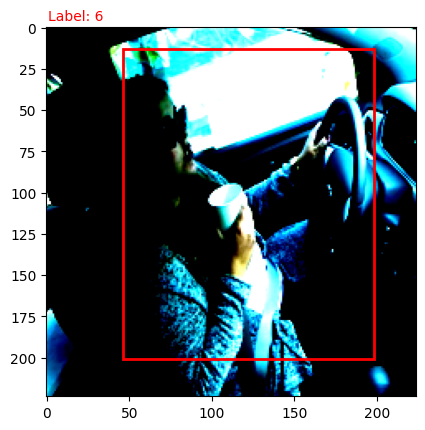

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


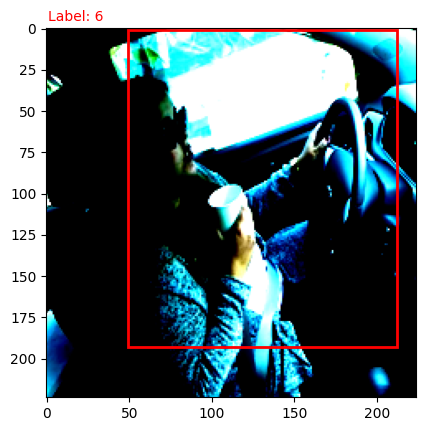

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


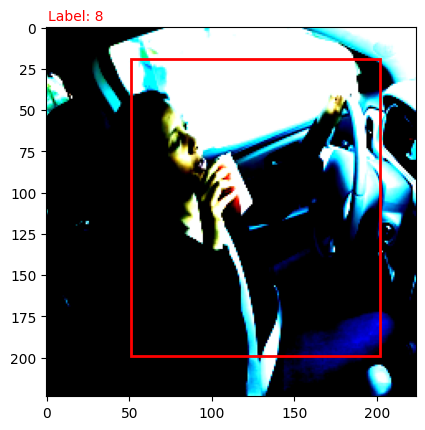

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


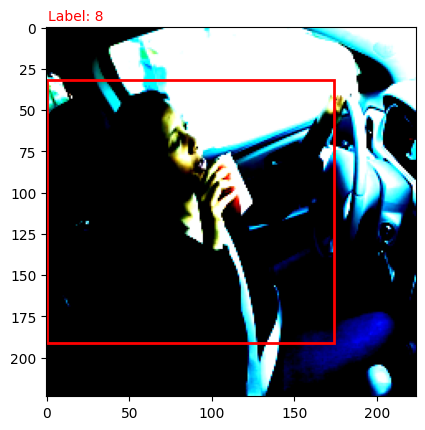

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


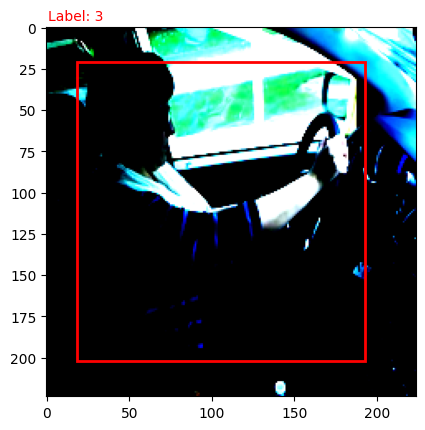

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


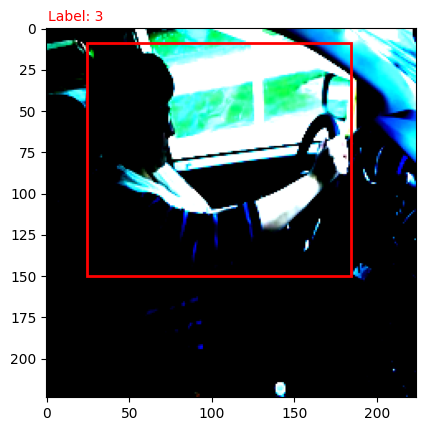

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


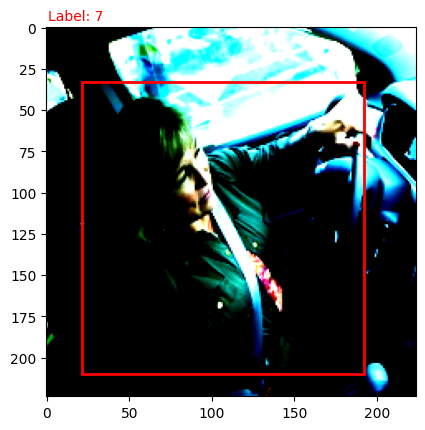

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


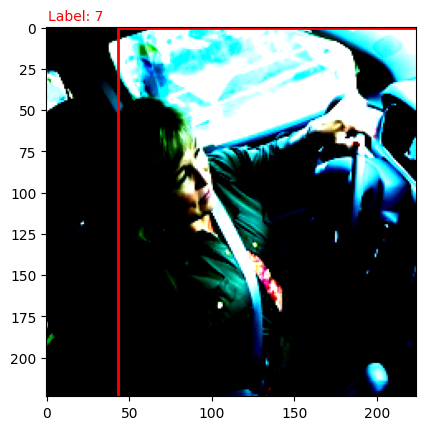

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


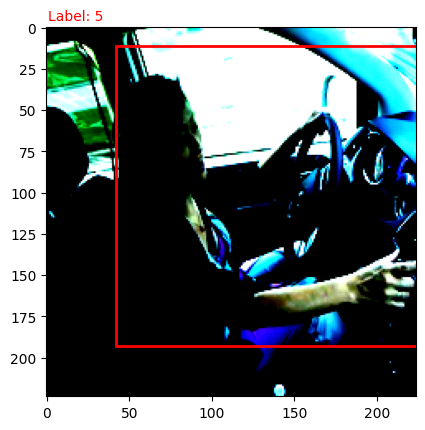

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


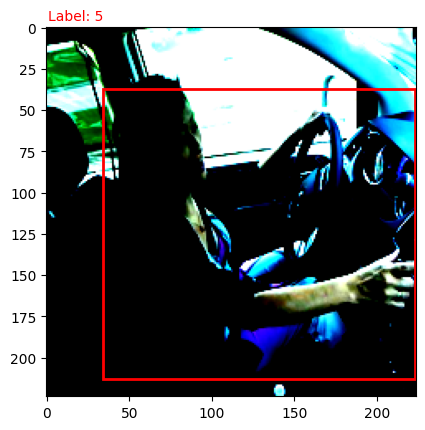

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


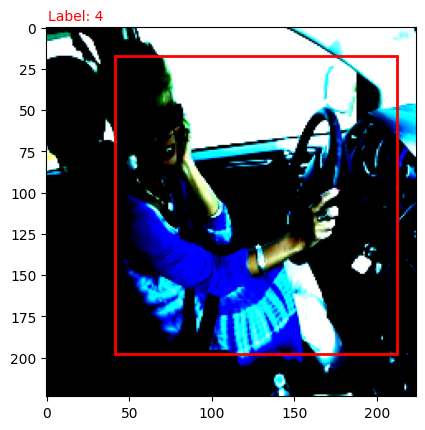

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


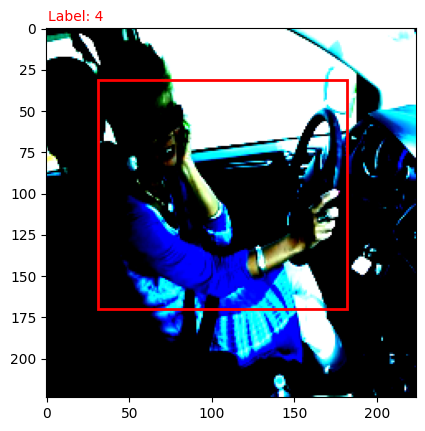

In [19]:

# Select a random subset of samples from the test dataset
num_samples_to_visualize = 10 # You can adjust this number based on your preference
random_test_samples = random.sample(list(test_dataloader), num_samples_to_visualize)

# Visualize the randomly selected samples along with predicted bounding boxes
with torch.no_grad():
    for images, (labels, bbox) in random_test_samples:
        images, labels, bbox = images.to(device), labels.to(device), bbox.to(device)

        # Forward pass to get predictions
        label_output, bbox_output = model(images)

        # Assuming your show_image_with_bbox function takes image, labels, and predicted_bbox as arguments
        # You may need to adjust this depending on the specifics of your function
        show_image_with_bbox(images[0].cpu(), (labels[0].cpu(), bbox_output[0].cpu()))
        show_image_with_bbox(images[0].cpu(), (labels[0].cpu(), bbox[0].cpu()))


# Show the plots
plt.show()